In [2]:
import pandas as pd
import numpy as np

In [3]:
data_frame = pd.read_parquet('./dataset/relevance_challenge_valid.parquet')

In [ ]:
def softmax(x):
    # Compute the exponential values for each element in the input array
    exps = np.exp(x - np.max(x))

    # Compute the softmax values by dividing the exponential of each element by the sum of exponentials
    return exps / np.sum(exps)  

In [ ]:
data_frame['probabilities'] = data_frame['raw_prediction'].apply(softmax)

In [ ]:
data_frame['pred'] = data_frame['raw_prediction'].apply(lambda x: np.argmax(x))

In [ ]:
x_values = []
y_values = []
counts = []
for j in range(3000):
    filtered_data = data_frame[data_frame['pred'] == j]
    if not filtered_data.empty:
        x_values.append(j)
        y_values.append(filtered_data['distance'].mean())
        counts.append(len(filtered_data['distance']))


In [ ]:
mean_distance_pred = pd.DataFrame([x for x in zip(x_values,y_values,counts)])

mean_distance_pred.rename(columns={0: 'feature'}, inplace=True)
mean_distance_pred.rename(columns={1:'mean_distance'},inplace=True)
mean_distance_pred.rename(columns={2:'counts'},inplace=True)

mean_distance_pred_t = mean_distance_pred[mean_distance_pred['counts'] >= 100]
mean_distance_pred_t.describe()

,feature,mean_distance,counts
count,124.000000,124.000000,124.000000
mean,323.475806,3200.795064,273.645161
std,462.741626,1998.821039,248.174447
min,0.000000,493.514270,100.000000
25%,43.500000,1741.740018,129.750000
50%,139.000000,2797.943047,174.000000
75%,438.250000,4310.125920,311.250000
max,2347.000000,10564.948403,1388.000000


In [ ]:
valid_pred = mean_distance_pred['feature'].to_list()

In [ ]:
data_frame = data_frame[data_frame['pred'].isin(valid_pred)]

In [ ]:
bins = [0, 0.1, 0.2, 0.3, 1.0]

probabilities = data_frame['probabilities'].values
probabilities

array([array([7.3262299e-06, 3.1586867e-06, 1.8454843e-06, ..., 3.4390405e-06,
              1.7382778e-06, 1.4658847e-06], dtype=float32)                   ,
       array([1.2205189e-06, 1.4805465e-06, 4.8549100e-06, ..., 9.6833992e-07,
              1.8104382e-06, 1.8591088e-06], dtype=float32)                   ,
       array([4.9958048e-06, 4.3765172e-06, 3.5352220e-06, ..., 4.1862900e-06,
              1.8424200e-06, 1.5242344e-06], dtype=float32)                   ,
       ...,
       array([1.3649012e-03, 5.6243024e-04, 1.2793902e-03, ..., 7.1128510e-05,
              4.2985790e-04, 2.2850082e-04], dtype=float32)                   ,
       array([1.1903144e-03, 7.0683629e-04, 1.3186556e-03, ..., 8.2090621e-05,
              2.4253859e-04, 2.1134102e-04], dtype=float32)                   ,
       array([1.2246306e-03, 1.6635128e-03, 1.6548340e-03, ..., 5.1828687e-05,
              2.4977321e-04, 3.1500243e-04], dtype=float32)                   ],
      dtype=object)

In [ ]:
histograms = []
for row in probabilities:
    histograms.append(np.histogram(row, bins=bins)[0])

In [ ]:
histograms = np.array(histograms)
histograms = np.delete(histograms, 0, 1)
histograms

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [ ]:
column_names = [f'{bins[i]}_{bins[i+1]}' for i in range(len(bins) - 1)]
histograms = histograms.T

In [ ]:
data_frame[column_names[1]] = histograms[0]
data_frame[column_names[2]] = histograms[1]
data_frame[column_names[3]] = histograms[2]

In [ ]:
data_frame['peaks'] = data_frame['0.1_0.2'] + data_frame['0.2_0.3'] + data_frame['0.3_1.0']
data_frame.sort_values('confidence', ascending=True, inplace=True)
data_frame['distance'].describe()

count    55350.000000
mean      3260.978350
std       4202.391081
min          0.751505
25%        378.965748
50%       1254.280157
75%       4598.103009
max      19791.642460
Name: distance, dtype: float64

In [ ]:
data_set = data_frame[['confidence','peaks','distance']]
data_set['features'] = data_set[['confidence' ,'peaks']].values.tolist()
data_set['label'] = data_set['distance'].apply(lambda x: 1/x)

data_set.drop(['confidence','peaks','distance'], axis=1, inplace=True)

/tmp/ipykernel_3880/3143293065.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set['features'] = data_set[['confidence' ,'peaks']].values.tolist()
/tmp/ipykernel_3880/3143293065.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set['label'] = data_set['distance'].apply(lambda x: 1/x)
/tmp/ipykernel_3880/3143293065.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()
model.fit(data_set['features'].tolist(), data_set['label'].tolist())

LinearRegression()

In [ ]:
data_frame['score'] = data_frame['confidence'] * model.coef_[0] + data_frame['peaks'] * model.coef_[1]
data_frame.sort_values('score', ascending=False, inplace=True)
data_frame_filtered = data_frame.iloc[0:int(0.1*len(data_frame))]
data_frame_filtered['distance'].describe()

count     5535.000000
mean       655.377445
std       1986.663024
min          2.974029
25%         32.149999
50%         82.422675
75%        297.806394
max      17147.333877
Name: distance, dtype: float64

In [ ]:
data_frame_filtered.describe()

,label,confidence,distance,pred,0.1_0.2,0.2_0.3,0.3_1.0,peaks,score
count,5535.000000,5535.000000,5535.000000,5535.000000,5535.000000,5535.000000,5535.000000,5535.000000,5535.000000
mean,1117.669919,0.499479,655.377445,824.029088,0.852575,0.364408,0.867931,2.084914,0.021479
std,868.671302,0.226955,1986.663024,790.498971,1.303556,0.617184,0.550398,1.176975,0.007152
min,1.000000,0.124816,2.974029,1.000000,0.000000,0.000000,0.000000,1.000000,0.012582
25%,312.000000,0.310683,32.149999,208.000000,0.000000,0.000000,1.000000,1.000000,0.015316
50%,928.000000,0.453711,82.422675,531.000000,0.000000,0.000000,1.000000,2.000000,0.019527
75%,1864.500000,0.676044,297.806394,1243.000000,1.000000,1.000000,1.000000,3.000000,0.026776
max,2995.000000,0.989569,17147.333877,2995.000000,6.000000,3.000000,2.000000,6.000000,0.037884


In [12]:
data_frame

,text,coordinates,label,raw_prediction,confidence,distance,text_length
246274,i'm at jalboot village in al ahmadi https://t....,"[47.78220261841334, 28.796369578665622]",1478,"[-0.16533367, 5.490072, -0.07687697, -0.028137...",0.097776,413.620188,59
19954,just posted a photo @ fringes https://t.co/ma1...,"[-114.60882437411358, 51.21439841204866]",469,"[-2.382054, -0.10486849, 0.36622486, -0.755341...",0.158510,7096.152333,53
4850,"ok, cleveland. here's the plan.\n\nwe need you...","[-75.0323028333211, 39.476737451506004]",385,"[-2.481499, -2.6620083, -0.20655325, -0.289278...",0.175566,607.165365,106
108015,@maisamo15677972 esgotada,"[-46.45847010250085, -5.46301167598722]",2323,"[3.0630562, -1.9455369, -1.4932183, -1.8799204...",0.015767,1200.366641,25
278357,@mzfrancesfx @moore10112 perfect date night!!,"[-91.9513874234886, 42.12479709049989]",682,"[-2.7112045, -2.0834854, 0.080568545, -0.49260...",0.010079,6900.667485,45
...,...,...,...,...,...,...,...
15798,"at 8:00 am mst, 1 wsw livingston [park co, mt]...","[-110.70732338679572, 45.838853258540645]",621,"[-0.35992363, 0.6696297, 0.7446083, -0.1418141...",0.882542,106.481047,105
416650,mais uma semana que vou ter que trabalhar na m...,"[-47.66169063555496, -19.573247529168484]",2383,"[3.0054696, -2.373546, -0.7675718, -1.2578157,...",0.013376,1222.321539,77
513367,"i was told today that my work ethic, commitmen...","[31.18067834529374, -29.445030391027498]",451,"[-3.443683, -2.9995954, 0.74820805, 0.24476698...",0.006585,16978.013750,111
437102,@asismedpy https://t.co/l60pbikvwg,"[-57.66387147382696, -25.518556132351215]",48,"[0.1884924, 1.6122415, -0.0250822, -0.5814621,...",0.027170,16055.944000,34


In [4]:
data_frame['text'] = data_frame['text'].str.replace(r'@[\w]+','')
data_frame['text'] = data_frame['text'].str.replace(r'https?://\S+|www\.\S+','')

/tmp/ipykernel_39763/3900086980.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data_frame['text'] = data_frame['text'].str.replace(r'@[\w]+','')
/tmp/ipykernel_39763/3900086980.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data_frame['text'] = data_frame['text'].str.replace(r'https?://\S+|www\.\S+','')


In [5]:
data_frame['text_length'] = data_frame['text'].str.len()

In [6]:
data_frame.sort_values('text_length', ascending=False, inplace=True)

In [7]:
data_frame['text_length'].describe()

count    55350.000000
mean        63.776802
std         65.583460
min          0.000000
25%         18.000000
50%         41.000000
75%         85.000000
max        330.000000
Name: text_length, dtype: float64

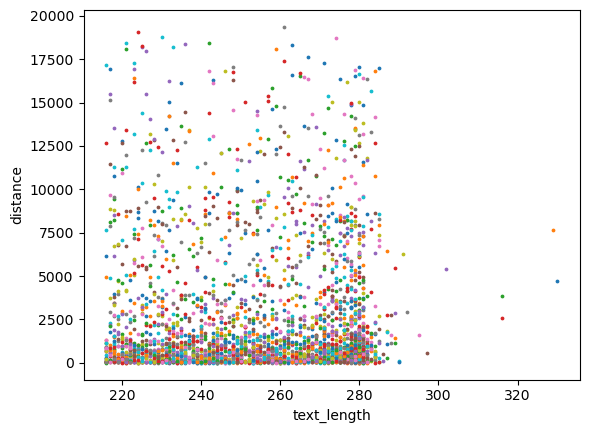

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(sharex=True, sharey=True)

for j in range(3000):
    y_values = data_frame['distance'].iloc[j]
    x_values = data_frame['text_length'].iloc[j]
    ax.scatter(x_values, y_values, s=3, alpha=1)


plt.xlabel('text_length')
plt.ylabel('distance')
plt.show()


Text(0, 0.5, 'distance')

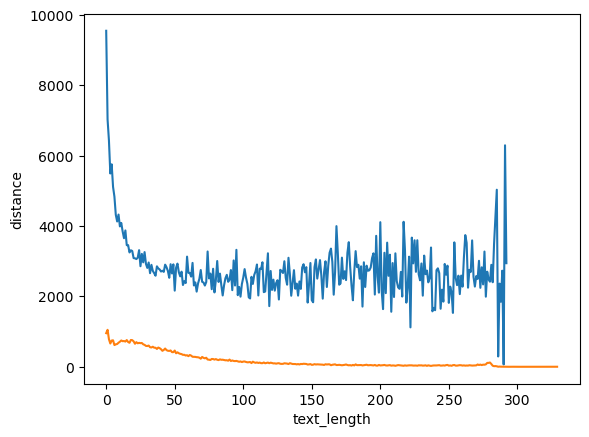

In [10]:
x_values = [i for i in range (330)]
y_values = [data_frame[data_frame['text_length'] == i]['distance'].mean() for i in range(330)]

plt.plot(x_values, y_values)
plt.xlabel('text_length')
plt.ylabel('distance')

Text(0, 0.5, 'count')

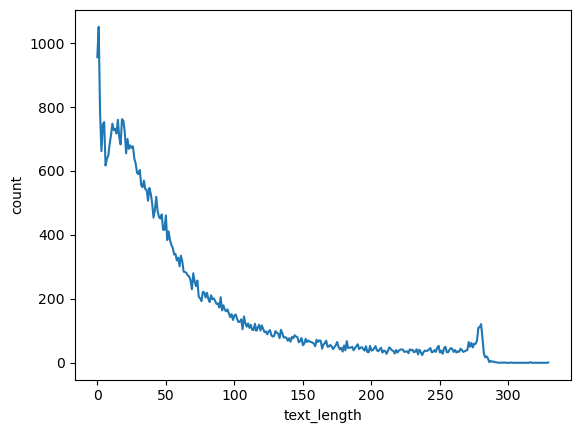

In [12]:
counts = [len(data_frame[data_frame['text_length'] == i]['distance']) for i in range(330)]
x_values = [i for i in range (330)]

plt.plot(x_values, counts)
plt.xlabel('text_length')
plt.ylabel('count')

In [ ]:
#hence as there are large number of small tweets and for small sized tweets the mean distance is quite high